# **X-means clustering on Cyclists dataset**
from: https://github.com/annoviko/pyclustering/

In [1]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
import numpy as np
import pandas
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler

Let's import the dataset

In [2]:
# Load the dataset
cyclists_df = pandas.read_csv('../dataset/cyclists_outlier.csv')

numeric_columns = cyclists_df.select_dtypes(include=[np.number]).columns

# Specify the columns to keep
columns_to_keep = ["avg_relative_position", "mean_sq", "career_level"]

#### **Features normalization**

Standardize ```cyclists_df``` by scaling each feature to have a mean of 0 and a standard deviation of 1.

In [3]:
scaler = StandardScaler()
scaler.fit(cyclists_df[columns_to_keep])
cyclist_normalized_df = scaler.transform(cyclists_df[columns_to_keep])

Set up the X-means grid search

In [4]:
start_centroids = 2
random_state = 42 

# Initialize the centers with K-Means++ using the seed
initial_centers = kmeans_plusplus_initializer(cyclist_normalized_df, start_centroids, random_state=random_state).initialize()

# Run X-Means using the same seed
x_means = xmeans(
    cyclist_normalized_df, 
    initial_centers, 
    kmax=5, 
    tolerance=1.5, 
    repeat=50, 
    random_state=random_state, 
    ccore=False,
    criterion=0     # BIC criterion
)
x_means.process()

In [5]:
# Extract clustering results: clusters and their centers
clusters = x_means.get_clusters()
centers = x_means.get_centers()

for i, cluster in enumerate(clusters):
    print(f"Cluster {i} shape: {len(cluster)}")

Cluster 0 shape: 2182
Cluster 1 shape: 685
Cluster 2 shape: 609


Extracting labels from clusters

In [6]:
n_clusters = len(clusters)
labels = {index: cluster_label for cluster_label, cluster in enumerate(clusters) for index in cluster}

xmeans_labels = [labels[i] for i in sorted(labels)]


In [30]:
# Calculate SSE
sse = 0
for i, cluster in enumerate(clusters):
    cluster_points = cyclist_normalized_df[cluster]
    center = centers[i]
    sse += np.sum((cluster_points - center) ** 2)

print('Davies Bouldin Score: \t%s' % davies_bouldin_score(cyclist_normalized_df, xmeans_labels)) 
print('Silhouette: \t\t%s' % silhouette_score(cyclist_normalized_df, xmeans_labels))
print('SSE: \t\t\t%s' % sse)


Davies Bouldin Score: 	0.8664175633191245
Silhouette: 		0.41700018706860714
SSE: 			4535.163403982024


## Results Visualization

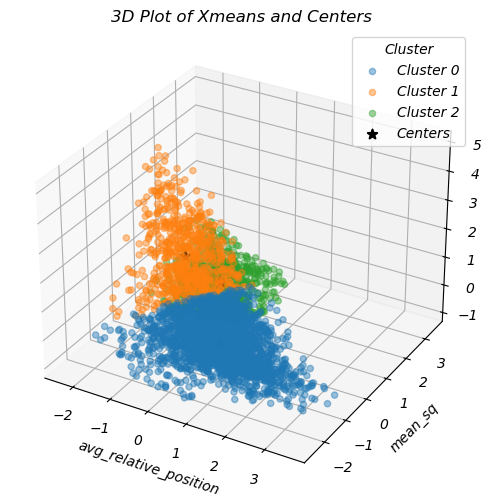

In [9]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the clusters with transparency
for cluster_label, cluster in enumerate(clusters):
    points = cyclist_normalized_df[cluster]
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], alpha=0.44, label=f'Cluster {cluster_label}')

# Plot the centers with a distinct color and larger marker size
centers = np.array(centers)
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='black', marker='*', s=50, alpha=1, edgecolors='black', linewidths=1.5, label='Centers')

ax.set_xlabel(columns_to_keep[0])
ax.set_ylabel(columns_to_keep[1])
ax.set_zlabel(columns_to_keep[2])
plt.title('3D Plot of Xmeans and Centers')
plt.legend(title='Cluster')
plt.show()


### PCA

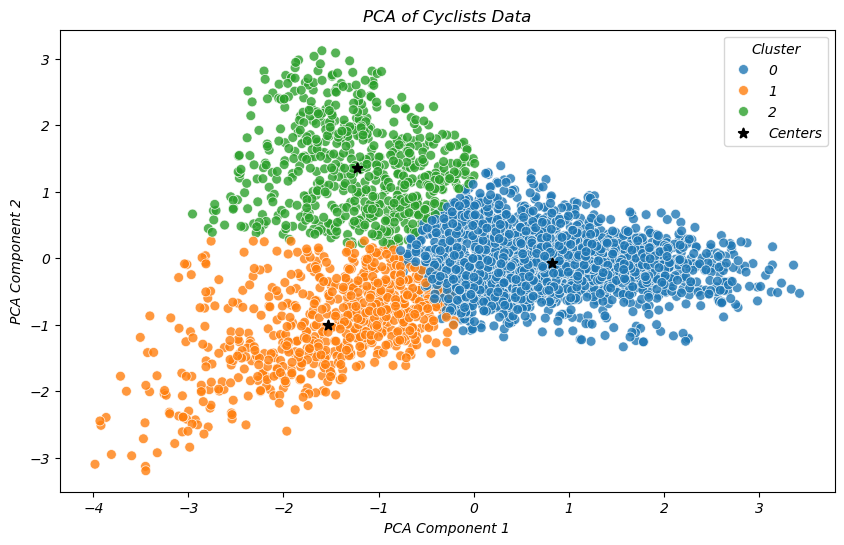

In [10]:
# Perform PCA to reduce the dimensionality to 2 components
pca = PCA(n_components=2)
x_pca = pca.fit_transform(cyclist_normalized_df)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=x_pca, columns=['PCA1', 'PCA2'])
pca_df['cluster'] = xmeans_labels

# Transform the centers to the PCA space
centers_pca = pca.transform(centers)

# Plot the PCA components with seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='cluster', palette='tab10', s=50, alpha=0.8)

# Plot the centers
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', marker='*', s=50, edgecolors='black', linewidths=1.5, label='Centers')

plt.title('PCA of Cyclists Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

### Pair Plot

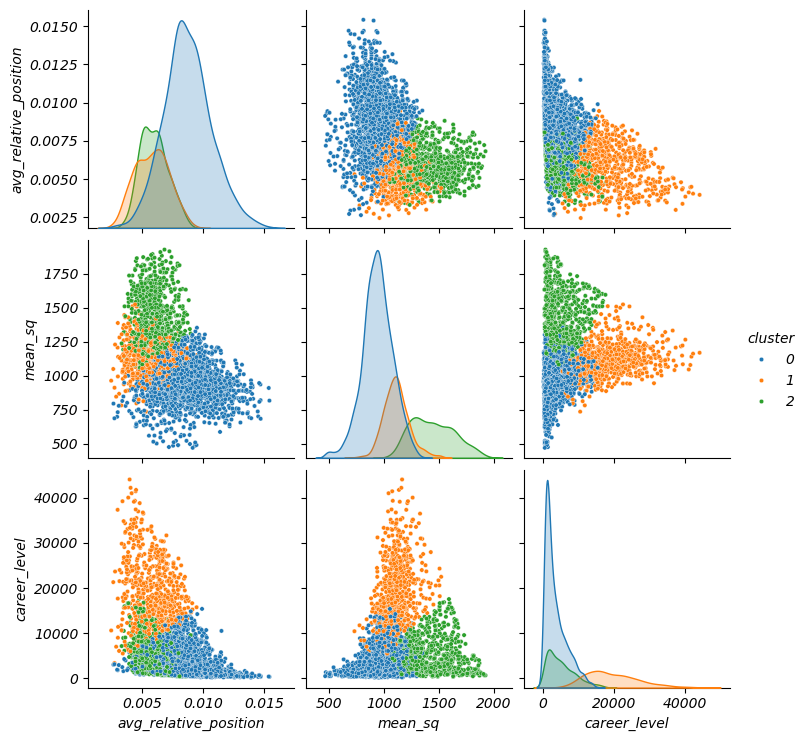

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

labels = x_means.predict(cyclist_normalized_df)
labels = pandas.DataFrame(labels, columns=["cluster"])

cyclist_normalized_df_with_labels = pandas.DataFrame(cyclist_normalized_df, columns=cyclists_df[columns_to_keep].columns)
cyclist_normalized_df_with_labels["cluster"] = labels["cluster"]

# Combine the normalized data with the original data
combined_df = pandas.concat([cyclists_df, cyclist_normalized_df_with_labels["cluster"]], axis=1)

# Create a pairplot
sns.pairplot(combined_df, hue="cluster", vars=columns_to_keep, palette="tab10", plot_kws={'s': 10, 'alpha': 1.0})
plt.show()



### Euclidean Distance Matrix

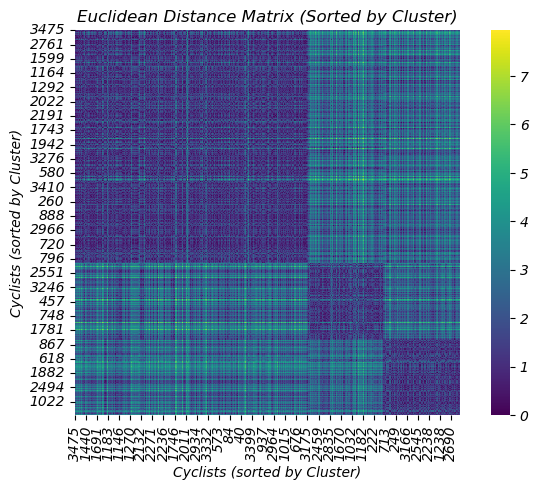

In [12]:
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# order the dataframe based on the cluster (from 0 = best to 2 = worst)
numeric_cyclists_df = cyclist_normalized_df_with_labels.sort_values(by='cluster')

# normalize the features
scaler = StandardScaler()
features = numeric_cyclists_df.drop(columns=['cluster']).select_dtypes(include=[np.number])
features_normalized = scaler.fit_transform(features)

# calculate the euclidean distance matrix excluding the cluster
features = numeric_cyclists_df.drop(columns=['cluster']).select_dtypes(include=[np.number])
distance_matrix = euclidean_distances(features)

# order the distance matrix based on the cluster order
distance_matrix_sorted = pd.DataFrame(distance_matrix, index=numeric_cyclists_df.index, columns=numeric_cyclists_df.index)

# plot
plt.figure(figsize=(8, 5))
sns.heatmap(distance_matrix_sorted, cmap='viridis', square=True)
plt.title('Euclidean Distance Matrix (Sorted by Cluster)')
plt.xlabel('Cyclists (sorted by Cluster)')
plt.ylabel('Cyclists (sorted by Cluster)')
plt.show()


### Labels distribution

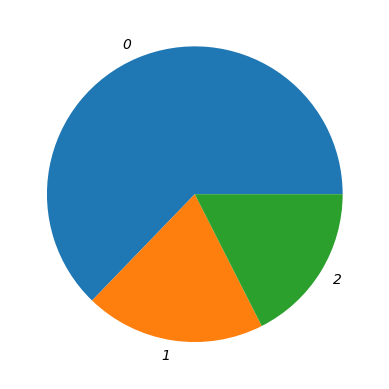

In [13]:
# Calculate list of label occurrencies for each cluster
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(np.array(xmeans_labels) == k))
    
label= range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show() 

## **Clusters characterization**

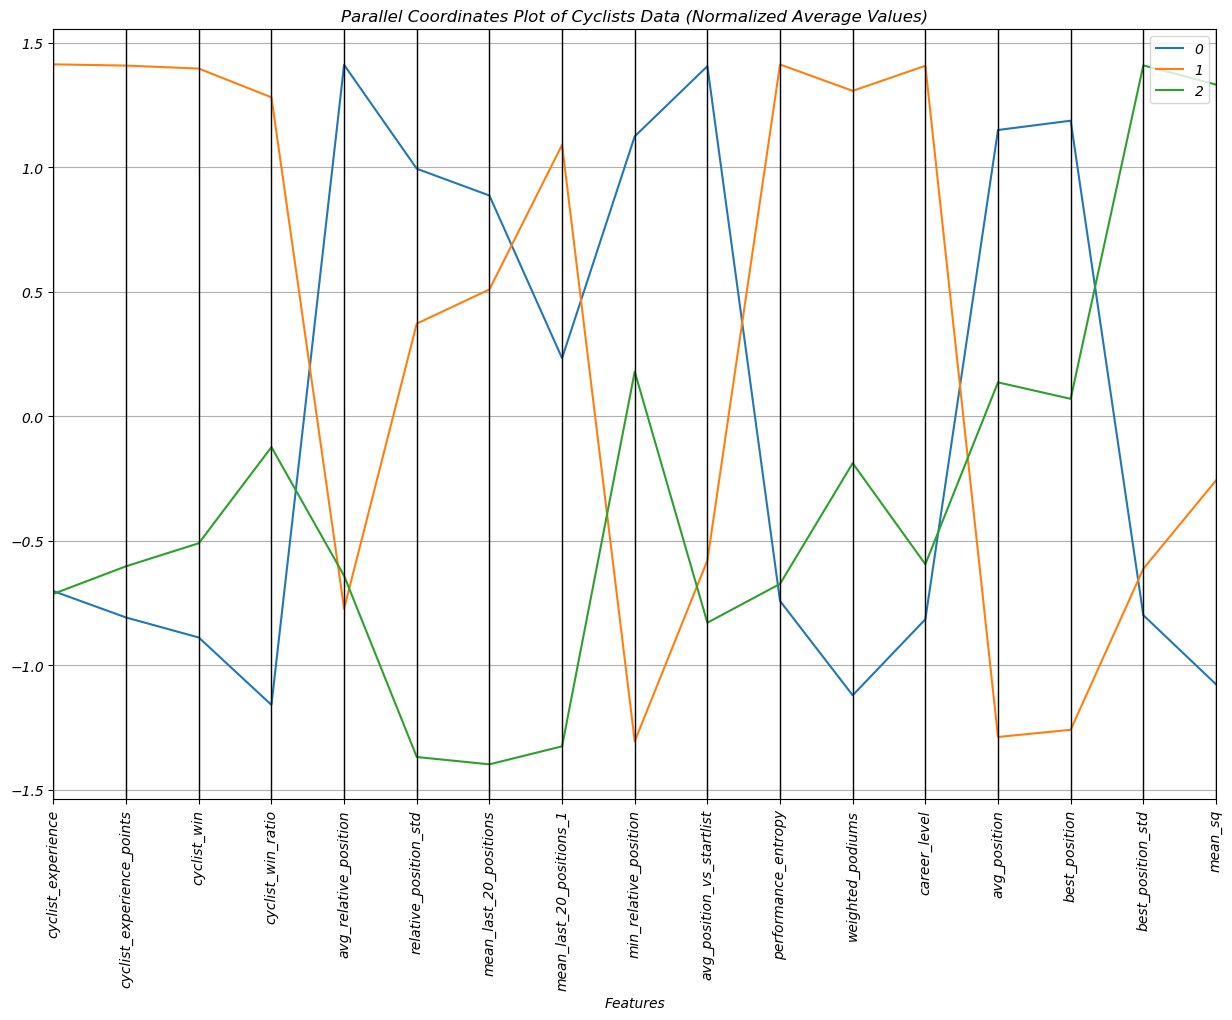

In [14]:
from pandas.plotting import parallel_coordinates

# Calculate the average values for each cluster
temp_df = cyclists_df[numeric_columns].assign(cluster=labels["cluster"])
average_values = temp_df.groupby('cluster')[numeric_columns].mean().reset_index()

# Normalize the average values
scaler = StandardScaler()
average_values_normalized = scaler.fit_transform(average_values[numeric_columns])

# Create a DataFrame for the normalized average values
average_values_normalized_df = pd.DataFrame(average_values_normalized, columns=numeric_columns)
average_values_normalized_df['cluster'] = average_values['cluster']


# Create a parallel coordinates plot
plt.figure(figsize=(15, 10))
parallel_coordinates(average_values_normalized_df.drop(columns=['birth_year']), class_column='cluster', color=sns.color_palette('tab10', n_clusters))
plt.title('Parallel Coordinates Plot of Cyclists Data (Normalized Average Values)')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.show()


#### **Characterization based on** ```top_cyclists```

This plot shows, for each cluster, the number of cyclists belonging to that cluster who have a specific value for the feature ```top_cyclists```. This feature was created using the ```career_level``` feature dividing cyclists into ranked segments such as top 10, top 20, and so on.

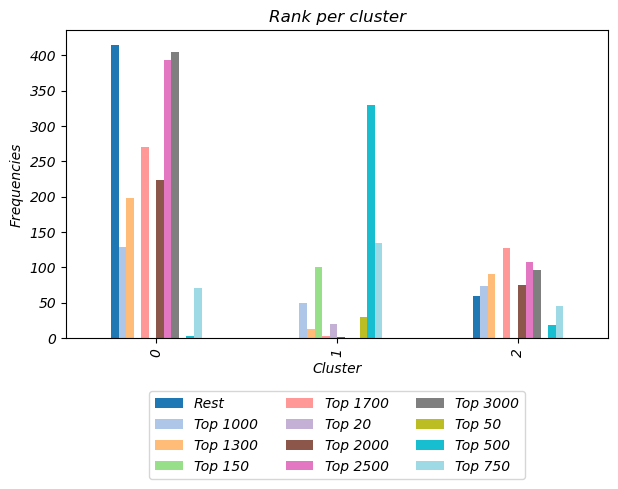

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(7, 4))
cyclists_df = cyclists_df.assign(cluster=labels["cluster"])

rank_xt_pct = pd.crosstab(cyclists_df['cluster'], cyclists_df['top_cyclists'])

rank_xt_pct.plot(
    kind='bar', 
    stacked=False, 
    title='Rank per cluster', 
    ax=ax, 
    xlabel="Cluster", 
    ylabel="Frequencies", 
    colormap='tab20'  
)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()


We expected a characterization based on the career level, as the clustering was built on features related to a cyclist's performance throughout their career. The plot showed that our goal cannot be reached. In fact, the clusters are not clearly separated based on *career level*.

- **Cluster 0**: Contains cyclists with the lowest *career level*. This is evident from the significant presence of the "rest" category, meaning those with the lowest rankings.

- **Cluster 1**: Represents cyclists with a higher average *career level*. This is the only cluster that includes top 20, top 50 and top 150 cyclists career level together.  

- **Cluster 2**: Corresponds to intermediate cyclists based on *career level*. Compared to Cluster 0, it includes more top 500 cyclists but less than cluster 1.  

We conclude saying that this characterization isn’t accurate. Upon reviewing the process, this makes sense because the clustering is based on a combination of features: *career level*, *average position*, and *startlist quality*. 

The clustering by “level” found using K-means is therefore a combination of these three features, *not just career level*. Consequently, it’s reasonable that the clusters aren’t perfectly characterized by *career level* alone.


**More precise visualization**

To give another try, starting with the plot shown above, we now perform the same analysis using a classes division based on the clustering results. The first class (representing the strongest cyclists) should include the top 685 cyclists. The second class (intermediate cyclists) includes cyclists ranked from position 685 to 1294 (the next 609 cyclists). Finally, the remaining cyclists from position 1294 onward form the third class. Bins are defined by an iterarive trial and error process.

In [16]:
# Sort the cyclists_df DataFrame by the 'career_level' column in descending order
sorted_cyclists_df = cyclists_df.sort_values(by='career_level', ascending=False)

# Define the bins and labels
[2182, 685, 609] # 3 clusters dim (worst - best - intermediate)
bins = [0, 685, 1294, 3476]
labels = ['top '+ str(bins[1]), 'top '+ str(bins[2]), 'top '+ str(bins[3])]

# Create a new column 'top_cyclists2' based on the bins
sorted_cyclists_df['top_cyclists2'] = pd.cut(range(1, len(sorted_cyclists_df) + 1), bins=bins, labels=labels, right=False)

# Add the 'top_cyclists2' column to the original cyclists_df
cyclists_df = cyclists_df.merge(sorted_cyclists_df[['_url', 'top_cyclists2']], on='_url', how='left')

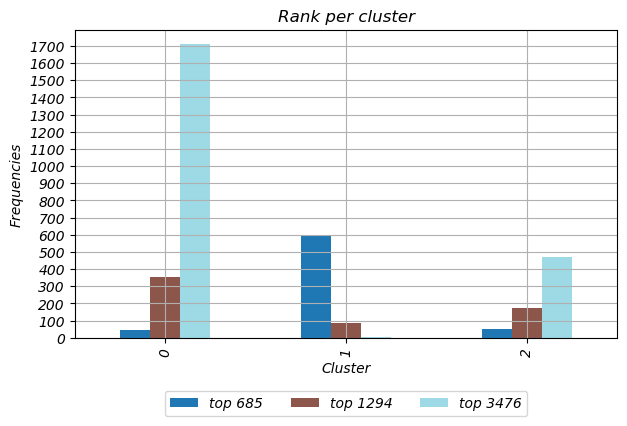

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize=(7, 4))

# create a crosstab table
rank_xt_pct = pd.crosstab(cyclists_df['cluster'], cyclists_df['top_cyclists2'])

#plotting the graph in distinct colors
rank_xt_pct.plot(
    kind='bar', 
    stacked=False, 
    title='Rank per cluster', 
    ax=ax, 
    xlabel="Cluster", 
    ylabel="Frequencies", 
    colormap='tab20' 
)

# add more ticks on the y-axis
ax.set_yticks(range(0, rank_xt_pct.values.max() + 1, 100))

# add a grid
ax.grid(True)

# put the legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()


Ideally, we would expect to see a single blue bar for cluster 1, a single brown bar for cluster 2, and a single light blue bar for cluster 0. This confirms our first consideration that the clustering is not based on career level alone.

#### **Parallel Coordinates Plot for Centroids**

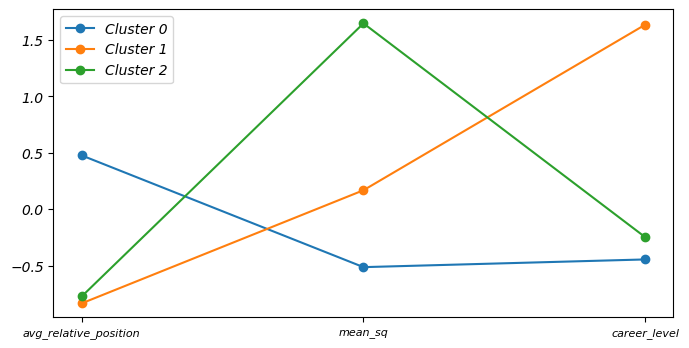

In [18]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(8, 4))
centers = x_means.get_centers()
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(columns_to_keep)), columns_to_keep, fontsize=8)
plt.legend(fontsize=10)
plt.show()

The plot shows a slightly unexpected result as in this clustering we expected that the cyclists considered "better" (with a high career level and a low average relative position) would also have a high average startlist quality. However, this is not the case when comparing the cluster of the best cyclists with the intermediates: the latter, despite having a lower career level and a higher average relative position, show a greater startlist quality. Conversely, the cluster of the worst cyclists behaves as expected. However the other results remain consistent with our expectations.

We can caraterrize cluste in the following way: 
- Cluster 0: **Worst Cyclists**
- Cluster 1: **Best Cyclists**
- Cluster 2: **Intermediate Cyclists**

**OBS:** This initial assumption will be later discussed and supported through upcoming characterization studies 

In [19]:
# fix the labels
cluster_labels = {2: 'Intermediate Cyclists', 1: 'Best Cyclists', 0: 'Worst Cyclists'}

In [20]:
# filter the dataframe for each cluster value
best_cyclists_df = cyclists_df[cyclists_df['cluster'] == 1]
intermediate_cyclists_df = cyclists_df[cyclists_df['cluster'] == 2]
worst_cyclists_df = cyclists_df[cyclists_df['cluster'] == 0]

#### **Analysis on the feature used for clustering** ```avg_relative_position```, ```career_level```, ```mean_sq```

In [21]:
# --- AVG RELATIVE POSITION ---

mean_avg_relative_position_per_cluster = cyclists_df.groupby('cluster')['avg_relative_position'].mean()

# Print the mean avg_relative_position for each cluster with custom labels
for cluster, mean_avg_relative_position in mean_avg_relative_position_per_cluster.items():
    print(f'{cluster_labels[cluster]}: Mean Avg Relative Position = {mean_avg_relative_position}')

Worst Cyclists: Mean Avg Relative Position = 0.0086997492064522
Best Cyclists: Mean Avg Relative Position = 0.005777621342964346
Intermediate Cyclists: Mean Avg Relative Position = 0.005954236103948675


In [22]:
# --- CAREER LEVEL ---

mean_wins_per_cluster = cyclists_df.groupby('cluster')['career_level'].mean()
# Print the mean number of cyclist wins for each cluster with custom labels
for cluster, mean_wins in mean_wins_per_cluster.items():
    print(f'cluster {cluster_labels[cluster]}: Mean Cyclist career level = {mean_wins}')

cluster Worst Cyclists: Mean Cyclist career level = 3460.3294558275134
cluster Best Cyclists: Mean Cyclist career level = 19246.29490343781
cluster Intermediate Cyclists: Mean Cyclist career level = 5029.496940626943


As expected, for all two features, the average values are better for the stronger clusters and worse for the weaker ones.

In [23]:
# --- MEAN SQ ---

mean_wins_per_cluster = cyclists_df.groupby('cluster')['mean_sq'].mean()
# Print the mean number of cyclist wins for each cluster with custom labels
for cluster, mean_wins in mean_wins_per_cluster.items():
    print(f'cluster {cluster_labels[cluster]}: Mean Cyclist startlist quality = {mean_wins}')

cluster Worst Cyclists: Mean Cyclist startlist quality = 942.7838916431504
cluster Best Cyclists: Mean Cyclist startlist quality = 1113.7770754263952
cluster Intermediate Cyclists: Mean Cyclist startlist quality = 1446.0205346364803


As we might have expected after seeing parallel coordinate plots for centroids, we do not have an indicative average starlist quality for the intermediate level. This means that this clustering does not considerably “reward” cyclists who have participated in higher level races. TODO

#### **Characterization based on** ```weighted_podiums```

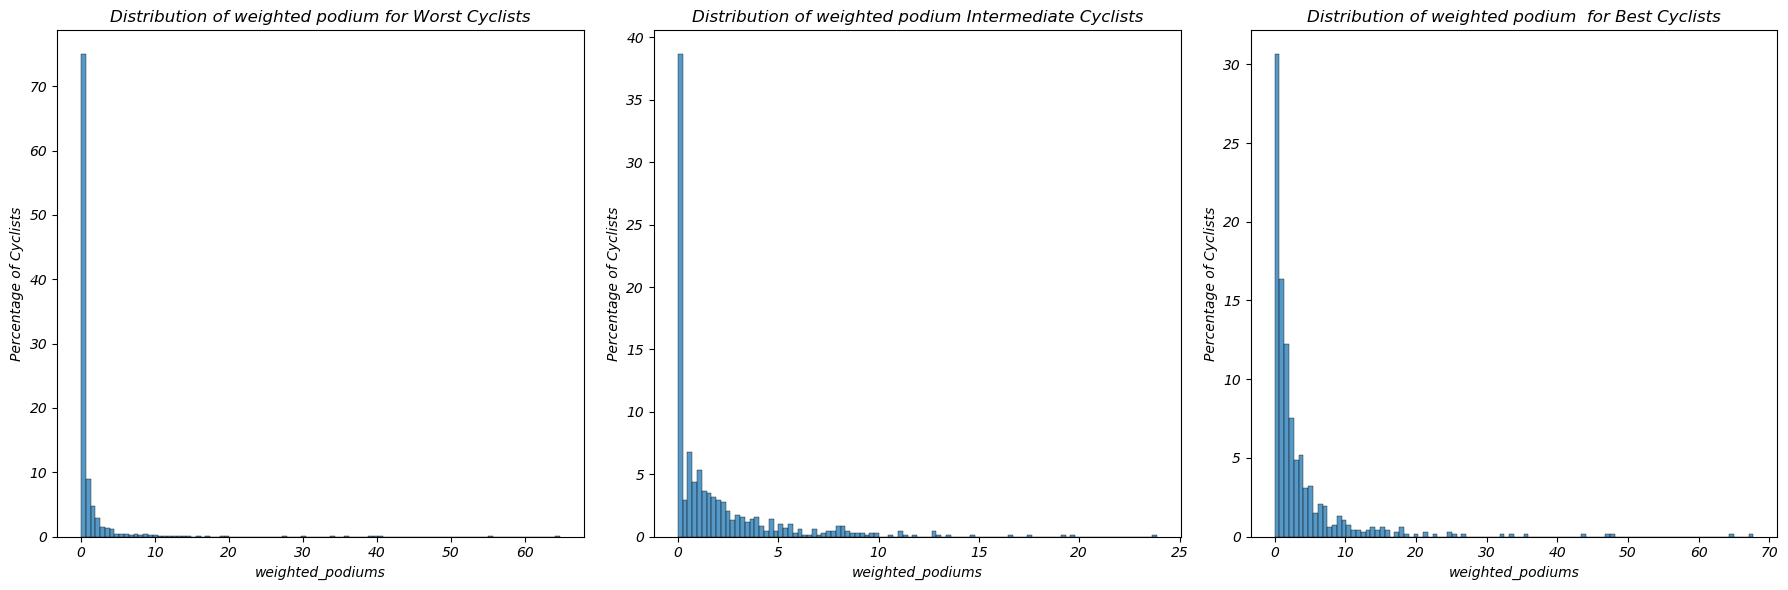

In [24]:
# Plot the distribution of stages won for all clusters
plt.figure(figsize=(18, 6))

# Plot for worst cyclists
plt.subplot(1, 3, 1)
sns.histplot(worst_cyclists_df['weighted_podiums'], bins=100, stat='percent')
plt.title('Distribution of weighted podium for Worst Cyclists')
plt.xlabel('weighted_podiums')
plt.ylabel('Percentage of Cyclists')

# Plot for intermediate cyclists
plt.subplot(1, 3, 2)
sns.histplot(intermediate_cyclists_df['weighted_podiums'], bins=100, stat='percent')
plt.title('Distribution of weighted podium Intermediate Cyclists')
plt.xlabel('weighted_podiums')
plt.ylabel('Percentage of Cyclists')

# Plot for best cyclists
plt.subplot(1, 3, 3)
sns.histplot(best_cyclists_df['weighted_podiums'], bins=100, stat='percent')
plt.title('Distribution of weighted podium  for Best Cyclists')
plt.xlabel('weighted_podiums')
plt.ylabel('Percentage of Cyclists')

plt.tight_layout()
plt.show()

In the first plot, we can see that a very large number of cyclists have this feature at 0, and then it quickly drops to 0 after a very small increase.

In contrast, in the second and third plots (showing higher-level cyclists), we see a similar pattern, but the decline is less sudden. There is a significant frequency of values that remain higher for a longer range of weighted podiums.

This indicates that in the two clusters with better-performing cyclists, there are cyclists who have achieved more significant podiums. The feature takes into account the importance of the race, meaning these cyclists tend to perform well in more important competitions.

#### **Characterization based on** ```cyclist_experience```

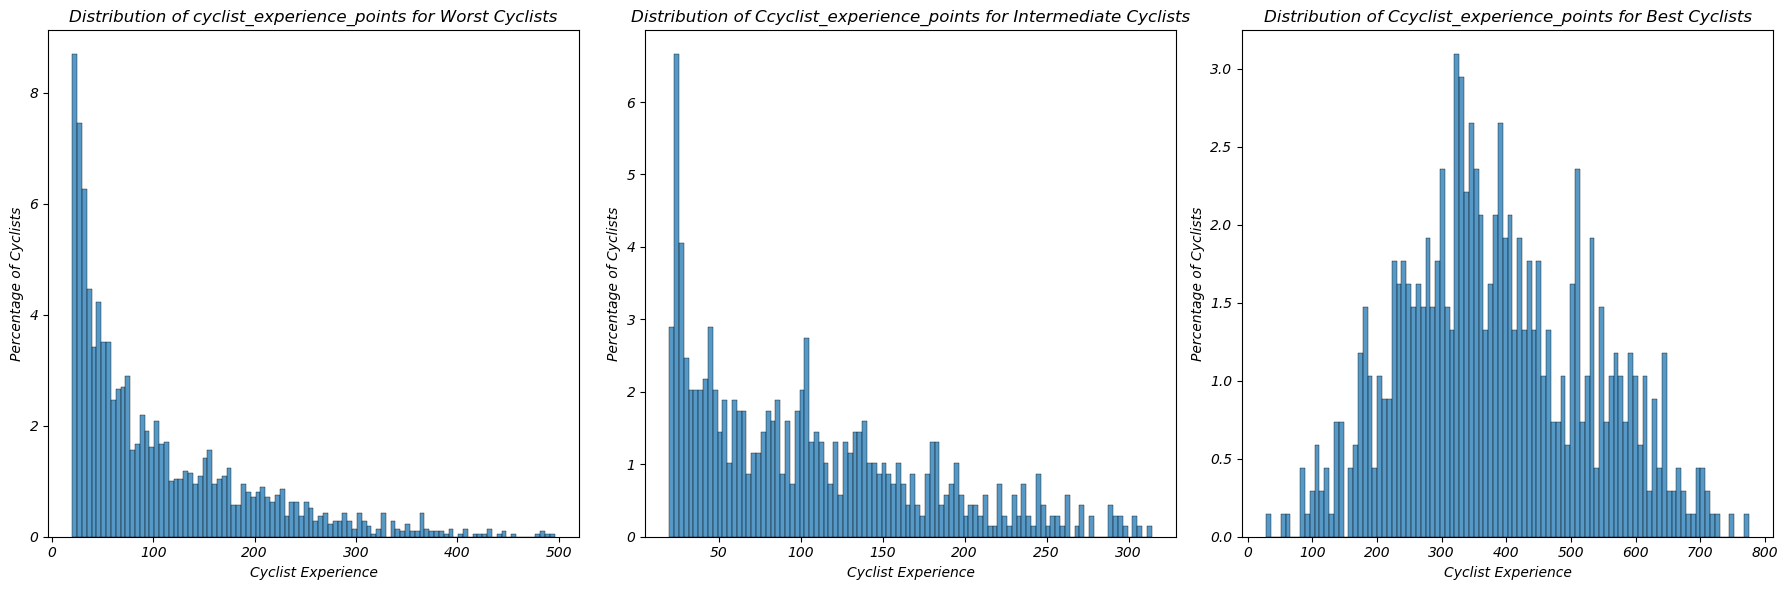

In [25]:
# Plot the normalized distribution of cyclist experience points for all clusters
plt.figure(figsize=(18, 6))

# Plot for worst cyclists
plt.subplot(1, 3, 1)
sns.histplot(worst_cyclists_df['cyclist_experience'], bins=100, stat='percent')
plt.title('Distribution of cyclist_experience_points for Worst Cyclists')
plt.xlabel('Cyclist Experience')
plt.ylabel('Percentage of Cyclists')

# Plot for intermediate cyclists
plt.subplot(1, 3, 2)
sns.histplot(intermediate_cyclists_df['cyclist_experience'], bins=100, stat='percent')
plt.title('Distribution of Ccyclist_experience_points for Intermediate Cyclists')
plt.xlabel('Cyclist Experience')
plt.ylabel('Percentage of Cyclists')

# Plot for best cyclists
plt.subplot(1, 3, 3)
sns.histplot(best_cyclists_df['cyclist_experience'], bins=100, stat='percent')
plt.title('Distribution of Ccyclist_experience_points for Best Cyclists')
plt.xlabel('Cyclist Experience')
plt.ylabel('Percentage of Cyclists')

plt.tight_layout()
plt.show()


We notice that the cyclists' experience is significantly higher in the cluster grouping the best cyclists (third one), but the difference is much less noticeable in the first two. Surely, having participated in many races contributes to the cyclist being classified with a high level.

#### **Characterization based on** ```best_position```

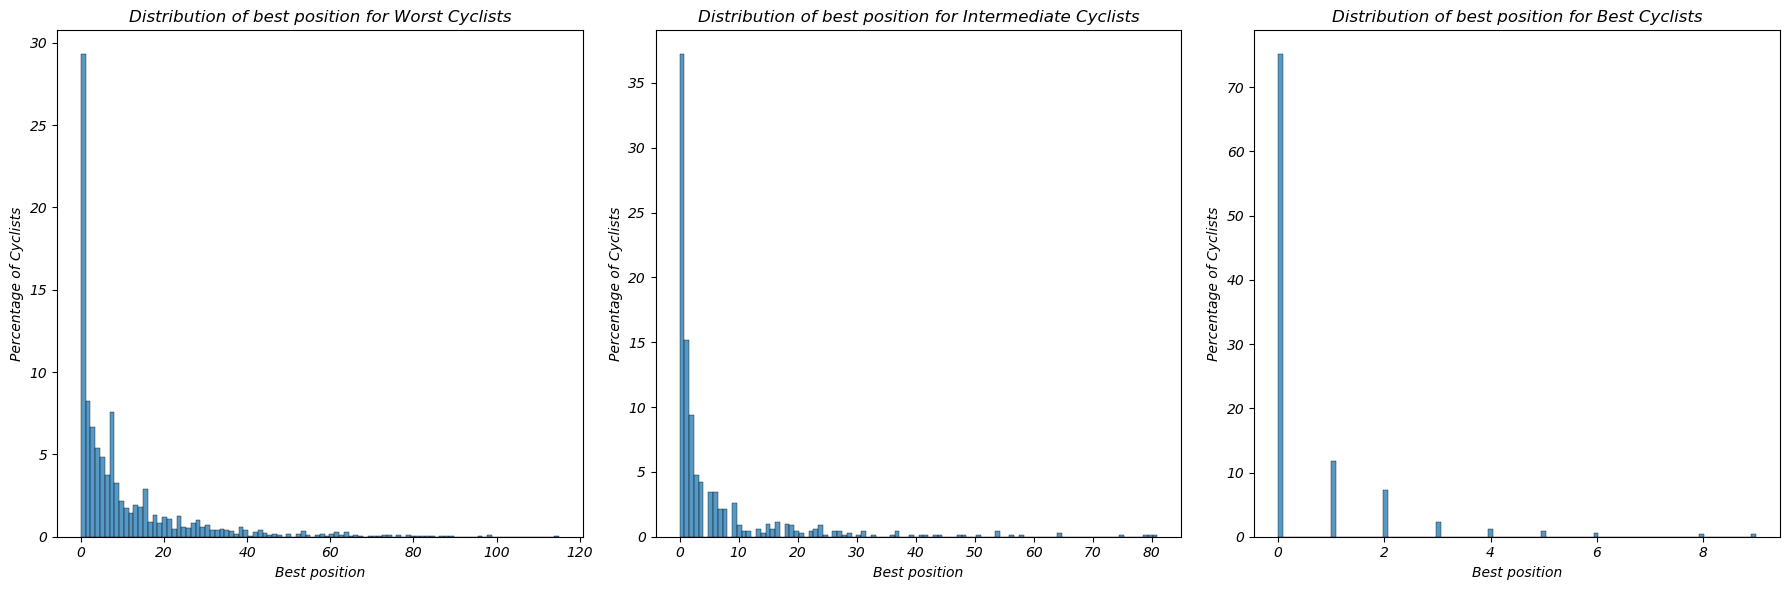

In [26]:
# Plot the distribution of best_position for all clusters
plt.figure(figsize=(18, 6))

# Plot for worst cyclists
plt.subplot(1, 3, 1)
sns.histplot(worst_cyclists_df['best_position'], bins=100, stat='percent')
plt.title('Distribution of best position for Worst Cyclists')
plt.xlabel('Best position')
plt.ylabel('Percentage of Cyclists')

# Plot for intermediate cyclists
plt.subplot(1, 3, 2)
sns.histplot(intermediate_cyclists_df['best_position'], bins=100, stat='percent')
plt.title('Distribution of best position for Intermediate Cyclists')
plt.xlabel('Best position')
plt.ylabel('Percentage of Cyclists')

# Plot for best cyclists
plt.subplot(1, 3, 3)
sns.histplot(best_cyclists_df['best_position'], bins=100, stat='percent')
plt.title('Distribution of best position for Best Cyclists')
plt.xlabel('Best position')
plt.ylabel('Percentage of Cyclists')

plt.tight_layout()
plt.show()

Here, we can notice that in the cluster grouping the best cyclists (third one), there is a significantly higher percentage of cyclists who have achieved top positions (0 or near 0), while in the other two clusters, the patterns are quite similar to each other and there are also minor placements.

#### **Characterization based on** ```performance_entropy```

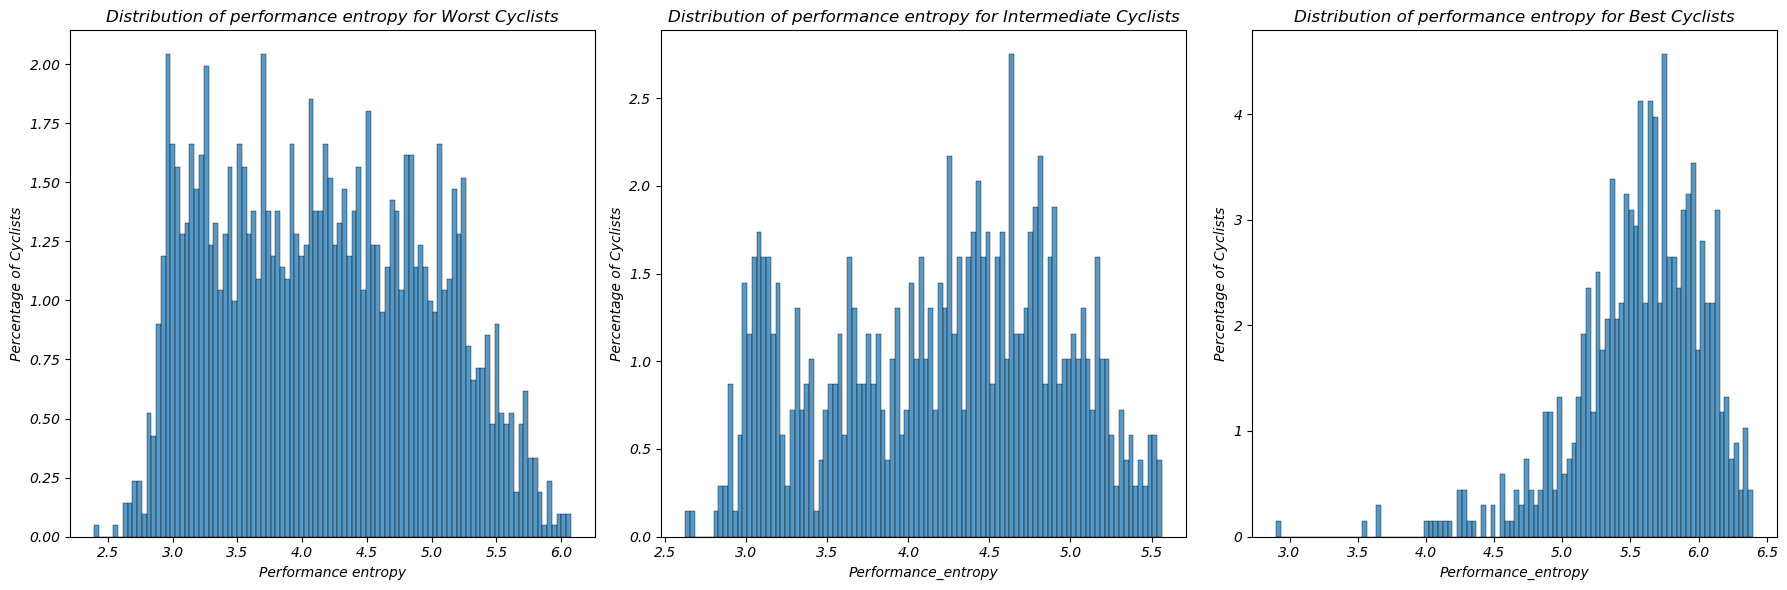

In [27]:
plt.figure(figsize=(18, 6))

# Plot for worst cyclists
plt.subplot(1, 3, 1)
sns.histplot(worst_cyclists_df['performance_entropy'], bins=100, stat='percent')
plt.title('Distribution of performance entropy for Worst Cyclists')
plt.xlabel('Performance entropy')
plt.ylabel('Percentage of Cyclists')

# Plot for intermediate cyclists
plt.subplot(1, 3, 2)
sns.histplot(intermediate_cyclists_df['performance_entropy'], bins=100, stat='percent')
plt.title('Distribution of performance entropy for Intermediate Cyclists')
plt.xlabel('Performance_entropy')
plt.ylabel('Percentage of Cyclists')

# Plot for best cyclists
plt.subplot(1, 3, 3)
sns.histplot(best_cyclists_df['performance_entropy'], bins=100, stat='percent')
plt.title('Distribution of performance entropy for Best Cyclists')
plt.xlabel('Performance_entropy')
plt.ylabel('Percentage of Cyclists')

plt.tight_layout()
plt.show()

In the first two clusters, the distribution is similar, while in the cluster with the best results, it is different, as a higher percentage of cyclists show high performance entropy (meaning more variability in their results). This might seem counterintuitive, but it's probably because these cyclists have participated in many more races, which increases the chances of getting both high and low results.

### **CONCLUSION**

The identified clusters align with expectations, reflecting feature distributions that indicate a cyclist's skill level. This confirms that X-means can effectively identify clusters based on a cyclist's "level."

By incorporating the career level as a feature, we account for not only performance outcomes but also a cyclist's activity throughout their career.

Consequently, a cyclist who has competed in only a few races and won them all may not be classified as "the best." This is because a low career level reflects both the number of races completed and the points earned, weighted by the importance of the competitions.

Looking at the plot of the coordinates and the distribution of features within the clusters, we observe:

1. **Cluster 0 (worst cyclists)**:  
   This is clearly the cluster of the worst cyclists. The cyclists have participated in relatively fewer races on average compared to the top cluster (*cyclist experience*), achieving high (so not good) placements in low-importance races (*mean_sq*).

2. **Cluster 1 (best cyclists)**:  
   In this cluster, we have cyclists who have competed in a large number of races (because they have a very high career level value) and have achieved good placements, on average slightly better than those of the cyclists in the intermediate cluster. The average startlist quality is quite low compared to the intermediate cluster which means that despite competing in many races many of them were not always at a high level.

3. **Cluster 2 (intermediate cyclists)**:  
   In this cluster, there are cyclists who have participated in a relatively small number of races compared to the cluster defined as "best cyclists", but they have achieved good placements and have competed in high-level events.


### Summary
- **Cluster 0** clearly represents the worst cyclists in terms of experience, results, and career level.  
- **Cluster 2** includes cyclists with a not so high experience but good great results in high quality of races.  
- **Cluster 1** includes cyclists with best average results respect the other cluster (slightly better than the intermediates), high experience and so high career level.  


This clustering has not provided very satisfactory results for us since there is no really clear distinction between strong cyclists and the intermediate ones.